In [ ]:
import numpy as np
import math
import copy

gamma = 0.4
acceleration_x = -0.03
acceleration_y = 0
N_e = 2

In [ ]:
class State:
    ball_x = 0
    ball_y = 0
    velocity_x = 0
    velocity_y = 0
    paddle_y = 0
    terminate = False
    
    
    def print_state(self):
        print(np.around(self.ball_x, 2) , " " , np.around(self.ball_y, 2) , " " ,  
              np.around(self.velocity_x, 2) , " " ,  np.around(self.velocity_y, 2) , " " ,  np.around(self.paddle_y, 2))
              
 
    def __init__(self, bx, by, vx, vy, p):
        self.ball_x = bx
        self.ball_y = by
        self.velocity_x = vx
        self.velocity_y = vy
        self.paddle_y = p
        
         
    def up(self):
        self.paddle_y = max(self.paddle_y - 0.04, 0)
        
        self.update()
        #print("in function up", match(self))

    def down(self):
        self.paddle_y = min(self.paddle_y + 0.04, 0.8)
        self.update()

    def update(self):
        global num_bounce
#         global state_tracker
        
        self.ball_x += self.velocity_x
        self.ball_y += self.velocity_y
        
        self.velocity_x += acceleration_x
        self.velocity_y += acceleration_y
        
        if self.ball_x >= 1:        # hitting right bound
            
            
            if self.ball_y >= self.paddle_y and self.ball_y <= self.paddle_y + 0.2:    # hitting paddle
                self.ball_x = 2 - self.ball_x
                #print("bounce")
                num_bounce += 1
#                 if curr_state not in state_tracker:
#                     #print(curr_state)
#                     state_tracker.append(curr_state)
                                
                self.velocity_x = -self.velocity_x + np.random.uniform(-0.015, 0.015)
                if self.velocity_x < 0:
                    self.velocity_x = min(-0.03, self.velocity_x)
                else:
                    self.velocity_x = max(0.03, self.velocity_x)
                if self.velocity_x > 1:
                    self.velocity_x = 1
                elif self.velocity_x < -1:
                    self.velocity_x = -1
                
                self.velocity_y += np.random.uniform(-0.03, 0.03)
                if self.velocity_y > 1:
                    self.velocity_y = 1
                elif self.velocity_y < -1:
                    self.velocity_y = -1
                    
                
                state_tracker = []
                
            else:    # missing paddle
                #print("terminate")
                self.ball_x = 2 - self.ball_x
#                 reward(state_tracker,-1)
#                 state_tracker = []
                self.terminate = True

            
        if self.ball_x <= 0:     # hitting left bound
            self.ball_x = -self.ball_x
            self.velocity_x = -self.velocity_x
        if self.ball_y <= 0:     # hitting upper bound
            self.ball_y = -self.ball_y
            self.velocity_y = -self.velocity_y
        if self.ball_y  >= 1:    # hitting right bound
            self.ball_y = 2 - self.ball_y
            self.velocity_y = -self.velocity_y

In [48]:
def match(s):
    b_x = math.floor(s.ball_x * 12)
    b_y = math.floor(s.ball_y * 12)
    if s.velocity_x > 0:
        v_x = 1
    else:
        v_x = 0    # velocity_x <= 0 map to 0

    v_y = 0
    if s.velocity_y > 0 and abs(s.velocity_y) > 0.015:
        v_y = 1
    elif s.velocity_y < 0 and abs(s.velocity_y) > 0.015:    #velocity_y < 0.015 map to 2
        v_y = 2

    #print("paddle_y", s.paddle_y)
    p = math.floor(s.paddle_y / (1 - 0.2) * 12)
    if p == 12:
        p = 11
    #print("p", p)

    return (b_x ,b_y, v_x, v_y, p)

In [49]:
def reward(state):
    next_ball_x = state.ball_x + state.velocity_x

    if next_ball_x >= 1:        # hitting right bound
        if state.ball_y >= state.paddle_y and state.ball_y <= state.paddle_y + 0.2:    # hitting paddle
            return 1
        else:     # missing paddle
            return -1
    return 0

In [50]:

def get_up(current_state):
    #print("up current", match(current_state))
    new_state = State(current_state.ball_x, current_state.ball_y, current_state.velocity_x, \
                      current_state.velocity_y, current_state.paddle_y)
    new_state.up()
    #print("new state", match(new_state))
    return new_state

def get_down(current_state):
    new_state = State(current_state.ball_x, current_state.ball_y, current_state.velocity_x, \
                      current_state.velocity_y, current_state.paddle_y)
    new_state.down()
    return new_state

def get_no_move(current_state):
    new_state = State(current_state.ball_x, current_state.ball_y, current_state.velocity_x, \
                      current_state.velocity_y, current_state.paddle_y)
    new_state.update()
    return new_state

In [51]:
def max_Q(current_state):
    (b_x ,b_y, v_x, v_y, p) = match(get_up(current_state))
    Q_up = Q_table[b_x][b_y][v_x][v_y][p][0]
    
    (b_x ,b_y, v_x, v_y, p) = match(get_down(current_state))
    #print(b_x ,b_y, v_x, v_y, p)
    Q_down = Q_table[b_x][b_y][v_x][v_y][p][1]
    
    (b_x ,b_y, v_x, v_y, p) = match(get_no_move(current_state))
    Q_no_move = Q_table[b_x][b_y][v_x][v_y][p][2]
    
    #print(Q_up, Q_down, Q_no_move)
    
    return max(Q_up, Q_down, Q_no_move)

In [52]:
def argmax_f(current_state):
    (b_x ,b_y, v_x, v_y, p) = match(get_up(current_state))
    if N_sa[b_x][b_y][v_x][v_y][p][0] < N_e:
        f_up = 0
    else:
        f_up = Q_table[b_x][b_y][v_x][v_y][p][0]
    
    (b_x ,b_y, v_x, v_y, p) = match(get_down(current_state))
    if N_sa[b_x][b_y][v_x][v_y][p][1] < N_e:
        f_down = 0
    else:
        f_down = Q_table[b_x][b_y][v_x][v_y][p][1]
        
    (b_x ,b_y, v_x, v_y, p) = match(get_no_move(current_state))
    if N_sa[b_x][b_y][v_x][v_y][p][2] < N_e:
        f_no_move = 0
    else:
        f_no_move = Q_table[b_x][b_y][v_x][v_y][p][2]
    
    if f_up == f_down and f_down == f_no_move:
        return np.random.randint(3)
    
    return np.argmax([f_up, f_down, f_no_move])

In [53]:
def alpha(state):
    (b_x ,b_y, v_x, v_y, p) = match(state)
    num_visited = N_sa[b_x][b_y][v_x][v_y][p][a] 
    return 60 / (60 + num_visited)

In [54]:
Q_table = np.zeros((12, 12, 2, 3, 12, 3)) # x, y, v_x, v_y, paddle, action
Q_additional_state = -1                   # x >= 1 state
N_sa = np.zeros((12, 12, 2, 3, 12, 3))    # x, y, v_x, v_y, paddle, action

s = State(0,0,0,0,0)
s_empty = True
a = 0
r = 0

In [55]:
'''action: 0-up, 1-down, 2-no_move'''
def Q_agent(current_state, t):
    global s_empty
    global s
    global a
    global r
    global N_sa
    global Q
    if current_state.terminate:
        (b_x ,b_y, v_x, v_y, p) = match(s)
        #Q_table[b_x][b_y][v_x][v_y][p][3] = reward(current_state)

    if s_empty is False:
        # increment N_s
        (b_x ,b_y, v_x, v_y, p) = match(s)
        #print(b_x ,b_y, v_x, v_y, p, a)
        N_sa[b_x][b_y][v_x][v_y][p][a] += 1
        #print(N_sa[b_x][b_y][v_x][v_y][p][a])
        
        Q_table[b_x][b_y][v_x][v_y][p][a] =  Q_table[b_x][b_y][v_x][v_y][p][a] + \
                            alpha(s)* (r + gamma * max_Q(current_state) - Q_table[b_x][b_y][v_x][v_y][p][a])
        
    else:
        s_empty = False
    
    #s.empty = False
    s = copy.deepcopy(current_state)
    #print("s", match(s))
    
    (b_x ,b_y, v_x, v_y, p) = match(current_state)
    a = argmax_f(current_state)
    
    r = reward(current_state)
    
    return a

In [56]:

t_ = 1
num_bounce = 0
total_num_bounce = 0


bounce_counter = []
state_counter = []
idx = []
for i in range(10000):
    idx.append(i)
    s = State(0.5, 0.5, 0.03, 0.01, 0.4)
    current_state = copy.deepcopy(s)
    print("round: ", i)
    num_bounce = 0
    while s.terminate is False:
        #s.print_state()
        next_action = Q_agent(current_state, t_)
        #print("current state before action", match(current_state))
        #print("next action", next_action)
        if next_action == 0:
            current_state.up()
        if next_action == 1:
            current_state.down()
        if next_action == 2:
            current_state.update()
        #print("current state", match(current_state))
    t_ += 1
    bounce_counter.append(num_bounce)
    print("bounce:", num_bounce)
    total_num_bounce += num_bounce
    visited_states = np.count_nonzero(Q_table)
    print("state visited: ",visited_states)
    state_counter.append(visited_states)

round:  0
bounce: 0
state visited:  1
round:  1
bounce: 0
state visited:  3
round:  2
bounce: 0
state visited:  5
round:  3
bounce: 2
state visited:  6
round:  4
bounce: 0
state visited:  8
round:  5
bounce: 0
state visited:  8
round:  6
bounce: 3
state visited:  9
round:  7
bounce: 0
state visited:  10
round:  8
bounce: 2
state visited:  10
round:  9
bounce: 3
state visited:  11
round:  10
bounce: 2
state visited:  11
round:  11
bounce: 0
state visited:  12
round:  12
bounce: 0
state visited:  12
round:  13
bounce: 0
state visited:  12
round:  14
bounce: 0
state visited:  12
round:  15
bounce: 0
state visited:  13
round:  16
bounce: 0
state visited:  13
round:  17
bounce: 4
state visited:  13
round:  18
bounce: 0
state visited:  14
round:  19
bounce: 0
state visited:  15
round:  20
bounce: 0
state visited:  15
round:  21
bounce: 5
state visited:  15
round:  22
bounce: 0
state visited:  16
round:  23
bounce: 7
state visited:  17
round:  24
bounce: 0
state visited:  17
round:  25
bounce

In [57]:
print("average bouncing per game: ", total_num_bounce / 10000)

print("totoal state visited after training: ", np.count_nonzero(Q_table))



average bouncing per game:  0.7249
totoal state visited after training:  33


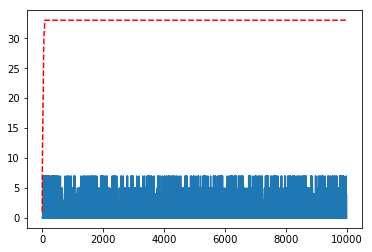

In [58]:
import matplotlib.pyplot as plt

idx = np.array(idx)
bounce_counter = np.array(bounce_counter)
state_counter = np.array(state_counter)

plt.plot(idx, state_counter, 'r--', label = 'visited states')
plt.show()


plt.plot(bounce_counter)

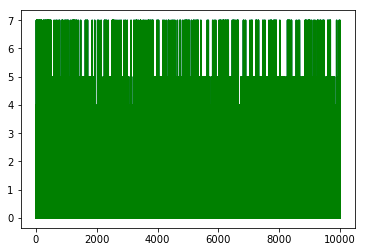

In [59]:
plt.plot(idx, bounce_counter, 'g', label = 'bounce_counter')
plt.show()


plt.plot(bounce_counter)

In [60]:
print (sorted(Q_table[np.nonzero(Q_table)],reverse=True), '\n')

[-0.39999999999999997, -0.40000000000000002, -0.40000000000000002, -0.40000000000000002, -0.40000000000000002, -0.40000000000000002, -0.40000000000000002, -0.40000000000000002, -0.40000000000000002, -0.40000000000000002, -0.40000000000000002, -0.40000000000000002, -0.54705545240344622, -0.58536305288925083, -0.60898514028946837, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0] 



In [61]:
print (sorted(N_sa[np.nonzero(N_sa)],reverse=True), '\n')

[6723.0, 6677.0, 6599.0, 3235.0, 2347.0, 2218.0, 2173.0, 1506.0, 1456.0, 1406.0, 1303.0, 1242.0, 1231.0, 1193.0, 1180.0, 1144.0, 1106.0, 1090.0, 1039.0, 923.0, 829.0, 829.0, 825.0, 819.0, 813.0, 758.0, 719.0, 681.0, 607.0, 606.0, 581.0, 569.0, 544.0, 540.0, 531.0, 507.0, 469.0, 418.0, 418.0, 409.0, 388.0, 383.0, 381.0, 139.0, 132.0, 129.0, 60.0, 50.0, 47.0, 15.0, 12.0] 



In [62]:
# print (N_sa[np.nonzero(N_sa)])

import statistics as stat

In [63]:
data = N_sa[np.nonzero(N_sa)]

In [64]:
print (stat.mean(data), stat.median(data), stat.mode(data))

print (stat.median_low(data), stat.median_high(data))

print (stat.median_grouped(data))

print (stat.harmonic_mean(data))

StatisticsError: no unique mode; found 2 equally common values

In [ ]:
print(stat.stdev(data))

In [ ]:
def Q_agent_test(current_state, t):
    global s_empty
    global s
    global a
    global r
    global N_sa
    global Q
    if current_state.terminate:
        (b_x ,b_y, v_x, v_y, p) = match(s)
        #Q_table[b_x][b_y][v_x][v_y][p][3] = reward(current_state)

    if s_empty is False:
        # increment N_s
        (b_x ,b_y, v_x, v_y, p) = match(s)
        
    else:
        s_empty = False
    
    #s.empty = False
    s = copy.deepcopy(current_state)
    #print("s", match(s))
    
    (b_x ,b_y, v_x, v_y, p) = match(current_state)
    a = argmax_f_test(current_state)
    
    r = reward(current_state)
    
    return a

In [ ]:
def argmax_f_test(current_state):
    (b_x ,b_y, v_x, v_y, p) = match(get_up(current_state))
    f_up = Q_table[b_x][b_y][v_x][v_y][p][0]
    
    (b_x ,b_y, v_x, v_y, p) = match(get_down(current_state))
    f_down = Q_table[b_x][b_y][v_x][v_y][p][1]
        
    (b_x ,b_y, v_x, v_y, p) = match(get_no_move(current_state))
    f_no_move = Q_table[b_x][b_y][v_x][v_y][p][2]
    
    if f_up == f_down and f_down == f_no_move:
        return np.random.randint(3)
    
    return np.argmax([f_up, f_down, f_no_move])

In [ ]:

t_ = 1
num_bounce = 0
total_num_bounce = 0

state_counter = []
bounce_counter = []

for i in range(1000):
    s = State(0.5, 0.5, 0.03, 0.01, 0.4)
    current_state = copy.deepcopy(s)
    print("round: ", i)
    num_bounce = 0
    while s.terminate is False:
        #s.print_state()
        next_action = Q_agent_test(current_state, t_)
        #print("current state before action", match(current_state))
        #print("next action", next_action)
        if next_action == 0:
            current_state.up()
        if next_action == 1:
            current_state.down()
        if next_action == 2:
            current_state.update()
        #print("current state", match(current_state))
    t_ += 1
    bounce_counter.append(num_bounce)
    print("bounce:", num_bounce)
    total_num_bounce += num_bounce
    num_state = np.count_nonzero(Q_table)
    print("state visited: ",num_state)
    state_counter.append(num_state)
    

In [ ]:
print("average bouncing per game: ", total_num_bounce / 1000)

print("totoal state visited after training: ", np.count_nonzero(Q_table))